# Approach

* This is a simplied version of YOLO. We take our 512x512 input, divide it into a 16x16 grid, each cell outputs five values:
    * The confidence that there is pneumonia present
    * The x, y, w, and h of the bounding box
* For labels we have assigned each box to the cell which is in it's center and have assigned the actual x, y, w, and h values to that cell.

# Network

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* The network outputs a 16x16x1 array of confidences and a 16x16x4 array of bounding boxes.
* The confidence cells have a sigmoid activation, the bboxes are linear.
* We use a binary cross entropy loss for the confidence and mean squared error for the bounding boxes.

# Predictions
* To generate our predictions we loop through each cell of the output, if the confidence is greater than 0.5 we append the corresponding bounding box to the prediction string. 

**Note:** Since each pixel only outputs one bounding box there is currently no non-max suppression. We can add this later if neccessary.

**Change Log:**
* v3 - changing output to 8x8 grid from 16x16; changed model to downsample one more time; adjusted network accordingly. 

In [ ]:
import os
import csv
import random
import pydicom
import numpy as np
import pickle
import pandas as pd
from skimage import measure
from skimage.transform import resize
import datetime
import math

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [27]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    w = boxes[:,2]
    h = boxes[:,3]
 
    x2 = x1 + w
    y2 = y1 + h

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (w + 1) * (h + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [2]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

In [3]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [4]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [5]:
with open('yolo_labels_8x8.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

# Load filenames

In [6]:
random.seed(72)

# load and shuffle filenames
folder = './stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = int(len(filenames) * 0.1)
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 23116
n valid samples 2568


 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [63]:
BATCH_SIZE = 20
IMAGE_SIZE = 512
CHECKPOINT_PATH = "yolo3_512.h5"

In [74]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # get filename without extension
        filename = filename.split('.')[0]
        label = pneumonia_locations[filename].copy()
        
        # remove the confidence and bboxes
        confs = label[:,:,0]
        boxes = label[:,:,1:]
        
        ## data augmentation may be complicated, let's do that later
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            # flip the image
            img = np.fliplr(img)
            
            # update our x coords - any cell that has a positive x coordinate should be subtracted from 1024
            mask = boxes[:,:,0] > 0
            boxes[mask, 0] = 1024 - boxes[mask,0]
            
            # flip our boxes lr on axis 0
            boxes = np.flip(boxes, axis=0)         
            
            # flip the confidences lr as well
            confs = np.flip(confs, axis=0)
            
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')

        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img, confs, boxes
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            
            # unzip images and masks
            imgs, confs, bboxes = zip(*items)
            
            # create numpy batch
            imgs = np.array(imgs)
            confs = np.expand_dims(np.array(confs), -1)
            bboxes = np.array(bboxes)
            
            labels = {"confidence_output": confs, "bboxes_output": bboxes}
            return imgs, labels
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

# Network

In [75]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
#     x = keras.layers.Conv2D(channels, (3,3), strides=(2,2), padding='same', use_bias=False)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x_1 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_1)
    x = keras.layers.LeakyReLU(0)(x)
    x_2 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x_2, inputs])
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_1])
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_2])
    return x

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(channels, 3, strides=(2,2), padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(channels*2, 1, padding='same', use_bias=False)(x)
    
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        
        # maybe try using stride of 2 instead of max pool here?
#         if d > 0:
        x = create_downsample(channels, x)
            
        for b in range(n_blocks):
            x = create_resblock(channels, x)
        
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(384, (3,3), padding='same', strides=(2,2), activation=None, name="downsample")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.01)(x)
    
    x_2 = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_2)
    x = keras.layers.LeakyReLU(0.01)(x)
    
#     x = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_2")(x)
#     x = keras.layers.BatchNormalization(momentum=0.9)(x)
#     x = keras.layers.LeakyReLU(0.01)(x)
    
    x = keras.layers.Conv2D(512, (3,3), padding='same', activation=None, name="final_conv")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.01)(x)
    
    c = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_1_c", kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
    c = keras.layers.BatchNormalization(momentum=0.9)(c)
    c = keras.layers.LeakyReLU(0.01)(c)
    c = keras.layers.Dropout(0.25)(c)
    
    c = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_2_c", kernel_regularizer=keras.regularizers.l2(l=0.01))(c)
    c = keras.layers.BatchNormalization(momentum=0.9)(c)
    c = keras.layers.LeakyReLU(0.01)(c)
    c = keras.layers.Dropout(0.20)(c)
    
    b = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_1_b", kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.25)(b)
    
    b = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_2_b", kernel_regularizer=keras.regularizers.l2(l=0.01))(b)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.20)(b)
    
    confidence = keras.layers.Conv2D(1, (1,1), padding='same', activation=None, name="confidence_output")(c)
    boxes = keras.layers.Conv2D(4, (1,1), padding='same', activation="linear", name="bboxes_output")(b)
    
    model = keras.Model(inputs=inputs, outputs=[confidence, boxes])
    
    return model

# Train network


In [80]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.4 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.6 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    mean_iou = tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))
    return mean_iou

def adj_mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    y_true_pos = tf.reduce_max(y_true, axis=[1, 2, 3])
    
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

def binary_accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.round(tf.sigmoid(tf.reshape(y_pred, [-1])))
    
    acc = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32))
    return acc

def weighted_binary_cross_entropy(y_true, y_pred):
    weight = 150
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    weights = tf.multiply(tf.cast(weight, tf.float32), tf.cast(tf.greater(y_true, 0), tf.float32)) + 1
    xe = tf.losses.sigmoid_cross_entropy(multi_class_labels=y_true, logits=y_pred, weights=weights)
    
    return xe
    
def bbox_overlap_iou(y_true, y_pred):
    """
    Args:
        bboxes1: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    # flatten the data because it's easier that way
    bboxes1 = tf.reshape(y_true, (-1, 4))
    bboxes2 = tf.reshape(y_pred, (-1, 4))
    
    # split the components out
    x11, y11, w1, h1 = tf.split(bboxes1, 4, axis=1)
    x21, y21, w2, h2 = tf.split(bboxes2, 4, axis=1)
    
    # predictions of 0 width and 0 height can be ignored
#     mask = (w2 > 0) & (h2 > 0) #& (w1 > 0) & (h1 > 0)
    
#     x11 = tf.boolean_mask(x11,mask,name='boolean_mask',axis=0)
#     y11 = tf.boolean_mask(y11,mask,name='boolean_mask_2',axis=0)
#     w1 = tf.boolean_mask(w1,mask,name='boolean_mask_3',axis=0)
#     h1 = tf.boolean_mask(h1,mask,name='boolean_mask_4',axis=0)
    
#     x21 = tf.boolean_mask(x21,mask,name='boolean_mask_5',axis=0)
#     y21 = tf.boolean_mask(y21,mask,name='boolean_mask_6',axis=0)
#     w2 = tf.boolean_mask(w2,mask,name='boolean_mask_7',axis=0)
#     h2 = tf.boolean_mask(h2,mask,name='boolean_mask_8',axis=0)
    
    # calculate the other corners with the x, y and w, h
    # now we have the corners of each box
    x12 = x11 + w1
    y12 = y11 + h1
    x22 = x21 + w2
    y22 = y21 + h2
    
    # find the corners of the intersection
    xI1 = tf.maximum(x11, x21)
    yI1 = tf.maximum(y11, y21)

    xI2 = tf.minimum(x12, x22)
    yI2 = tf.minimum(y12, y22)
    
    # get the intersection area, if the truth has no boxes it is 0
    true_boxes = tf.cast(tf.greater(w1 * h1, 0), tf.float32)
    inter_area = true_boxes * (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    # get the area of each box
    bboxes1_area = (w1 + 1) * (h1 + 1)
    bboxes2_area = (w2 + 1) * (h2 + 1)
    
    # union is area of both boxes - intersection
    union = (bboxes1_area + bboxes2_area) - inter_area + 1
    
    # reduce the mean so we have mean iou for our inputs
    return tf.reduce_mean(tf.maximum(inter_area / union, 0))

# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=24, n_blocks=1, depth=4)

losses = {
    "confidence_output": weighted_binary_cross_entropy,
    "bboxes_output": "mean_squared_error",
}
lossWeights = { "confidence_output": 10.0, "bboxes_output": 0.75 }

metrics_dict = {
    "confidence_output": binary_accuracy,
    "bboxes_output": [bbox_overlap_iou],
#     "bboxes_output": bbox_overlap_iou,
}

model.compile(optimizer='adam',
              loss=losses,
              loss_weights=lossWeights,
              metrics=metrics_dict)

# cosine learning rate annealing
def cosine_annealing(x):
    lr0 = 0.02
    epochs_drop = 5
    drop = 0.75
    lrate = lr0 * math.pow(drop, math.floor((1+x)/epochs_drop))
    return lrate

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

# create train and validation generators
folder = './stage_1_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_457 (Conv2D)             (None, 512, 512, 24) 216         input_20[0][0]                   
__________________________________________________________________________________________________
batch_normalization_584 (BatchN (None, 512, 512, 24) 96          conv2d_457[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_584 (LeakyReLU)     (None, 512, 512, 24) 0           batch_normalization_584[0][0]    
__________________________________________________________________________________________________
conv2d_458

In [81]:
model.load_weights(CHECKPOINT_PATH)

In [16]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=5, shuffle=True, verbose=1, initial_epoch=0)

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 1/5
1925/1926 [============================>.] - ETA: 0s - loss: 201.5946 - confidence_output_loss: 1.0692 - bboxes_output_loss: 706.3669 - confidence_output_binary_accuracy: 0.7230 - bboxes_output_bbox_overlap_iou: 0.0126
Epoch 00001: saving model to yolo3_512.h5
1926/1926 [==============================] - 1899s 986ms/step - loss: 201.6408 - confidence_output_loss: 1.0692 - bboxes_output_loss: 706.5490 - confidence_output_binary_accuracy: 0.7230 - bboxes_output_bbox_overlap_iou: 0.0126 - val_loss: 197.5861 - val_confidence_output_loss: 1.6128 - val_bboxes_output_loss: 662.7797 - val_confidence_output_binary_accuracy: 0.6550 - val_bboxes_output_bbox_overlap_iou: 0.0066
Epoch 2/5
1925/1926 [============================>.] - ETA: 0s - loss: 184.7163 - confidence_output_loss: 0.7619 - bboxes_output_loss: 681.1337 - confidence_output_binary_accuracy: 0.8008 - bboxes_output_bbox_overlap_iou: 0.0164
Epoch 00002: saving model to yolo3_512.h5
1926/1926 [==============================] -

In [29]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=10, shuffle=True, verbose=1, initial_epoch=8)

Epoch 9/10


/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1925/1926 [============================>.] - ETA: 0s - loss: 154.7671 - confidence_output_loss: 0.3409 - bboxes_output_loss: 593.1851 - confidence_output_binary_accuracy: 0.9145 - bboxes_output_bbox_overlap_iou: 0.0122
Epoch 00009: saving model to yolo3_512.h5
1926/1926 [==============================] - 1281s 665ms/step - loss: 154.7657 - confidence_output_loss: 0.3410 - bboxes_output_loss: 593.1741 - confidence_output_binary_accuracy: 0.9145 - bboxes_output_bbox_overlap_iou: 0.0122 - val_loss: 155.8742 - val_confidence_output_loss: 0.3775 - val_bboxes_output_loss: 595.2130 - val_confidence_output_binary_accuracy: 0.9130 - val_bboxes_output_bbox_overlap_iou: 0.0123
Epoch 10/10
1925/1926 [============================>.] - ETA: 0s - loss: 146.9397 - confidence_output_loss: 0.3216 - bboxes_output_loss: 564.4655 - confidence_output_binary_accuracy: 0.9188 - bboxes_output_bbox_overlap_iou: 0.0545
Epoch 00010: saving model to yolo3_512.h5
1926/1926 [==============================] - 1269s 6

In [51]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=20, shuffle=True, verbose=1, initial_epoch=15)

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 16/20
1443/1444 [============================>.] - ETA: 0s - loss: 81.5752 - confidence_output_loss: 0.2387 - bboxes_output_loss: 304.4149 - confidence_output_binary_accuracy: 0.9297 - bboxes_output_bbox_overlap_iou: 0.0065
Epoch 00016: saving model to yolo3_512.h5
1444/1444 [==============================] - 1232s 853ms/step - loss: 81.5926 - confidence_output_loss: 0.2388 - bboxes_output_loss: 304.4815 - confidence_output_binary_accuracy: 0.9297 - bboxes_output_bbox_overlap_iou: 0.0065 - val_loss: 179.3046 - val_confidence_output_loss: 0.4983 - val_bboxes_output_loss: 684.8120 - val_confidence_output_binary_accuracy: 0.9328 - val_bboxes_output_bbox_overlap_iou: 0.0045
Epoch 17/20
1443/1444 [============================>.] - ETA: 0s - loss: 73.0617 - confidence_output_loss: 0.2197 - bboxes_output_loss: 271.3778 - confidence_output_binary_accuracy: 0.9307 - bboxes_output_bbox_overlap_iou: 0.0042
Epoch 00017: saving model to yolo3_512.h5
1444/1444 [==============================] 

In [71]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=25, shuffle=True, verbose=1, initial_epoch=20)

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 21/25
1154/1155 [============================>.] - ETA: 0s - loss: 340.7525 - confidence_output_loss: 0.5888 - bboxes_output_loss: 662.5209 - confidence_output_binary_accuracy: 0.8697 - bboxes_output_bbox_overlap_iou: 0.0052
Epoch 00021: saving model to yolo3_512.h5
1155/1155 [==============================] - 1268s 1s/step - loss: 340.9388 - confidence_output_loss: 0.5889 - bboxes_output_loss: 662.8901 - confidence_output_binary_accuracy: 0.8697 - bboxes_output_bbox_overlap_iou: 0.0052 - val_loss: 354.5572 - val_confidence_output_loss: 0.5105 - val_bboxes_output_loss: 691.2412 - val_confidence_output_binary_accuracy: 0.8406 - val_bboxes_output_bbox_overlap_iou: 0.0156
Epoch 22/25
1154/1155 [============================>.] - ETA: 0s - loss: 324.9714 - confidence_output_loss: 0.4877 - bboxes_output_loss: 632.2716 - confidence_output_binary_accuracy: 0.8734 - bboxes_output_bbox_overlap_iou: 0.0063
Epoch 00022: saving model to yolo3_512.h5
1155/1155 [==============================] 

In [82]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=30, shuffle=True, verbose=1, initial_epoch=25)

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 26/30
1154/1155 [============================>.] - ETA: 0s - loss: 438.4859 - confidence_output_loss: 0.4222 - bboxes_output_loss: 571.1010 - confidence_output_binary_accuracy: 0.8963 - bboxes_output_bbox_overlap_iou: 0.0109
Epoch 00026: saving model to yolo3_512.h5
1155/1155 [==============================] - 1271s 1s/step - loss: 438.7153 - confidence_output_loss: 0.4223 - bboxes_output_loss: 571.4050 - confidence_output_binary_accuracy: 0.8963 - bboxes_output_bbox_overlap_iou: 0.0109 - val_loss: 568.3888 - val_confidence_output_loss: 0.5438 - val_bboxes_output_loss: 741.6189 - val_confidence_output_binary_accuracy: 0.9256 - val_bboxes_output_bbox_overlap_iou: 0.0081
Epoch 27/30
1154/1155 [============================>.] - ETA: 0s - loss: 435.7006 - confidence_output_loss: 0.4186 - bboxes_output_loss: 565.7815 - confidence_output_binary_accuracy: 0.8975 - bboxes_output_bbox_overlap_iou: 0.0202
Epoch 00027: saving model to yolo3_512.h5
1155/1155 [==============================] 

In [85]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=35, shuffle=True, verbose=1, initial_epoch=30)

Epoch 31/35


/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1154/1155 [============================>.] - ETA: 0s - loss: 369.9456 - confidence_output_loss: 0.3907 - bboxes_output_loss: 477.6052 - confidence_output_binary_accuracy: 0.9079 - bboxes_output_bbox_overlap_iou: 0.0080
Epoch 00031: saving model to yolo3_512.h5
1155/1155 [==============================] - 1203s 1s/step - loss: 370.3241 - confidence_output_loss: 0.3910 - bboxes_output_loss: 478.1071 - confidence_output_binary_accuracy: 0.9079 - bboxes_output_bbox_overlap_iou: 0.0080 - val_loss: 559.4145 - val_confidence_output_loss: 0.5512 - val_bboxes_output_loss: 728.1939 - val_confidence_output_binary_accuracy: 0.9096 - val_bboxes_output_bbox_overlap_iou: 0.0440
Epoch 32/35
 264/1155 [=====>........................] - ETA: 14:33 - loss: 348.1698 - confidence_output_loss: 0.3722 - bboxes_output_loss: 448.8548 - confidence_output_binary_accuracy: 0.9090 - bboxes_output_bbox_overlap_iou: 0.0049

KeyboardInterrupt: 

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


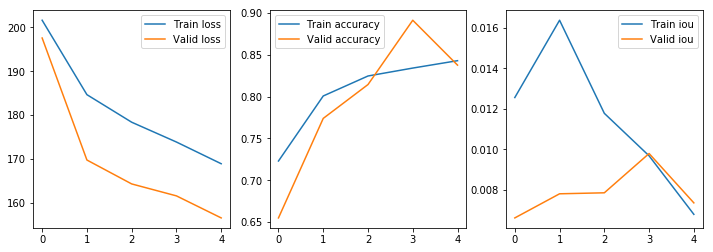

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["bboxes_output_bbox_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_bbox_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

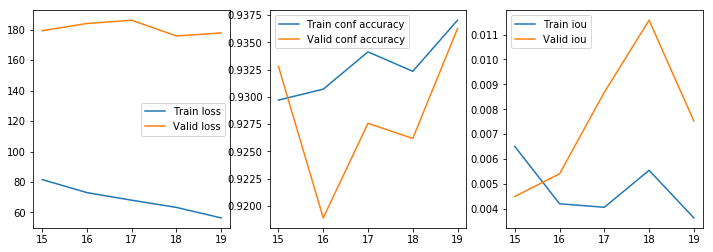

In [57]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train conf accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid conf accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["bboxes_output_bbox_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_bbox_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


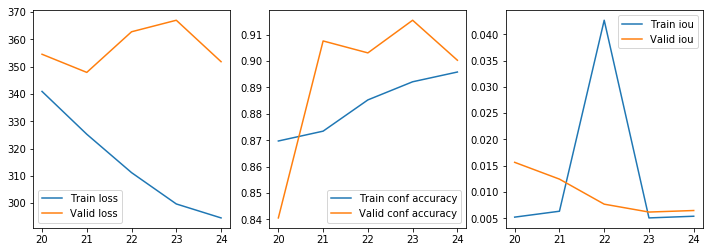

In [72]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train conf accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid conf accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["bboxes_output_bbox_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_bbox_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


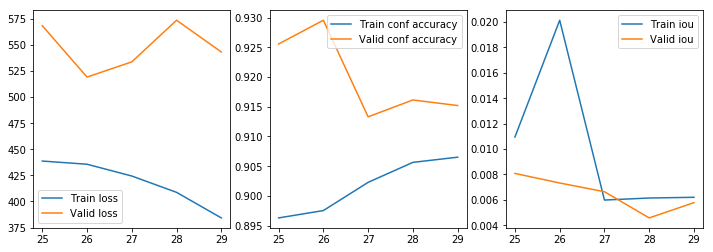

In [83]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train conf accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid conf accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["bboxes_output_bbox_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_bbox_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

## Sample Predictions

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


pred: 5 4 2 3 conf: 0.6406487399538389
pred: 6 4 4 7 conf: 0.808741110379551
pred: 6 5 2 3 conf: 0.6597025461684954
pred: 5 5 2 3 conf: 0.7819515759174863
pred: 5 4 2 3 conf: 0.648960976443367


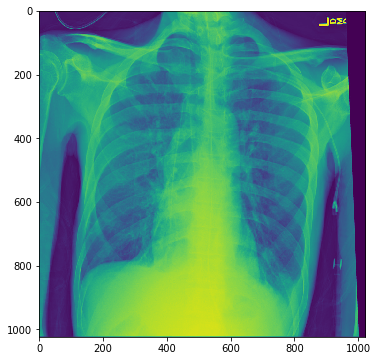

pred: 6 5 2 3 conf: 0.5971944312336886
pred: 8 6 3 4 conf: 0.619698758214312
pred: 13 9 5 7 conf: 0.8270580299052869
pred: 6 4 2 3 conf: 0.6305849834928624
pred: 20 14 8 10 conf: 0.7870833283508208
pred: 15 11 5 7 conf: 0.7984461979032226
pred: 10 8 4 6 conf: 0.7923076890192353
pred: 4 3 1 2 conf: 0.6766028266818807
pred: 15 10 6 8 conf: 0.8263729813028203
pred: 8 6 3 4 conf: 0.6633097374918316
pred: 17 11 6 8 conf: 0.8204494081964175
pred: 4 4 1 2 conf: 0.5684944721087489
pred: 3 2 1 2 conf: 0.5024940499937036


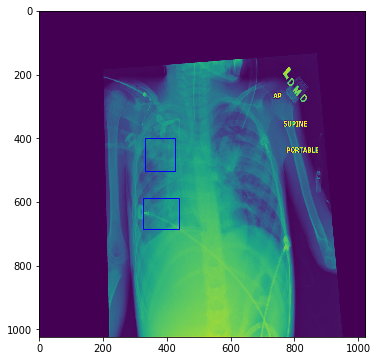

pred: 2 2 1 1 conf: 0.5980381615080845
pred: 4 3 1 2 conf: 0.5968969661729284
pred: 5 5 2 3 conf: 0.7713374054217347
pred: 6 4 2 4 conf: 0.7621410197373635


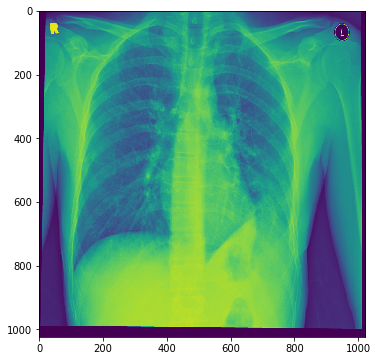

pred: 2 2 1 1 conf: 0.6164287868468602
pred: 3 2 1 1 conf: 0.6201543003190241
pred: 6 4 2 4 conf: 0.6849879555398153
pred: 3 3 1 2 conf: 0.519512080570062
pred: 9 6 3 5 conf: 0.7833497156530441
pred: 5 4 2 2 conf: 0.6134250519349858
pred: 9 6 3 5 conf: 0.7427534506019028


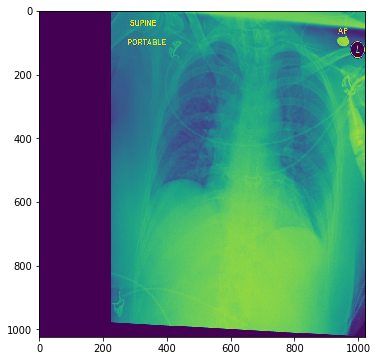

pred: 1 2 1 1 conf: 0.5978750089509449
pred: 3 4 1 2 conf: 0.7469627117025719
pred: 0 2 0 0 conf: 0.5398479367177722


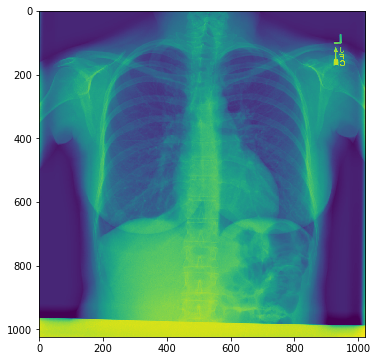

pred: 2 3 1 1 conf: 0.651992545149643


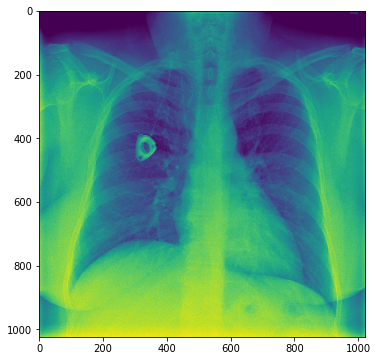

pred: 3 4 1 2 conf: 0.6918606415174541
pred: 1 2 0 0 conf: 0.5560260870683794
pred: 1 2 1 1 conf: 0.5937713737793543
pred: 0 2 0 0 conf: 0.5329056398022952


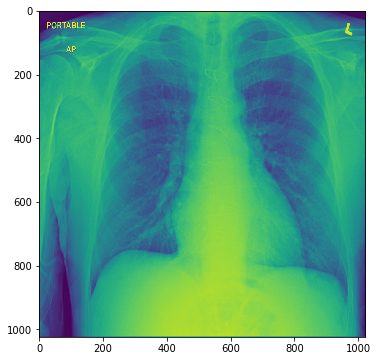

pred: 2 2 0 0 conf: 0.5274805252249367
pred: 3 3 1 1 conf: 0.6194658006957638
pred: 2 2 0 1 conf: 0.582389788476836
pred: 1 2 0 1 conf: 0.5368497667147817


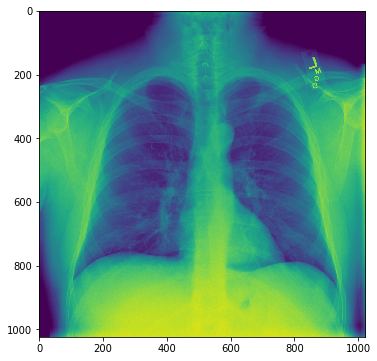

In [84]:
THRESHOLD = 0.5
OVERLAP = 0.3
# look at some sample predictions
samples = np.random.choice(valid_filenames, size=8, replace=False)

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    
    filename = filename.split('.')[0]
    
    f, ax = plt.subplots(figsize=(6, 6))
    plt.imshow(img)
    # get boxes for the truth
    if filename in pneumonia_locations:
        locs = pneumonia_locations[filename]
        for i in range(8):
            for j in range(8):
                pixel_data = locs[i,j,:]
                if pixel_data[0] > 0:
                    x, y, w, h = pixel_data[1:]
                    x = int(x)
                    y = int(y)
                    w = int(w)
                    h = int(h)
                    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    ax.add_patch(rect)
    
    # predict the image
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    yhat = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    
    conf = np.squeeze(yhat[0])
    bboxes = np.squeeze(yhat[1])
    boxes = []
    
    # loop through our predictions
    for i in range(8):
        for j in range(8):
            conf_ = sigmoid(conf[i, j])
            # if we have a prediction
            if conf_ > THRESHOLD:
                x,y,w,h = bboxes[i,j,:]
                x = int(x)
                y = int(y)
                w = int(w)
                h = int(h)
                print("pred:", x, y, w, h, "conf:", conf_)
                # if the boxes have width and height - the min in the training data is 40
                if w > 10 and h > 10:
                    boxes.append([x,y,w,h])
    
    # do non-max suppression of our boxes
    boxes = non_max_suppression_fast(np.array(boxes), OVERLAP)
    
    # plot our boxes
    for box in boxes:
        x,y,w,h = box
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Predict test images

In [ ]:
THRESHOLD = 0.5

# load and shuffle filenames
folder = './stage_1_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=3, image_size=IMAGE_SIZE, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    
    # predict batch of images
    conf_preds, bbox_preds = model.predict(imgs)
    
    # loop through batch
    for confs, bboxes, filename in zip(conf_preds, bbox_preds, filenames):
        predictionString = ""
        print(filename)
        boxes = []
        for i in range(16):
            for j in range(16):
                conf = sigmoid(confs[i, j, 0])
                if conf > THRESHOLD:
                    x, y, w, h = bboxes[i,j]
                    
                    # cast to ints
                    x = int(x)
                    y = int(y)
                    w = int(w)
                    h = int(h)
                    # the smallest boxes in the training data are 40 pixels, so exclude anything
                    # really small
                    if w > 10 and h > 10:
                        # make sure our boxes don't run off the edges of the images
                        w = np.minimum(w, 1024 - x)
                        h = np.minimum(h, 1024 - y)
                        boxes.append([x,y,w,h])

        # do our non-max suppression here
        boxes = non_max_suppression_fast(np.array(boxes), 0.3)
        
        # loop through our suppressed boxes and creat the prediction string
        for box in boxes:
            x,y,w,h = box
            # create the prediction string
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + ' '
            
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString

    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
    break
    
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']

now = datetime.datetime.now()
today = str(now)[:10]
submission_file = today + "_yolo_submission.csv" 
sub.to_csv(submission_file)

In [19]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f submission.csv -m "YOLOv2 512x512 35 epochs"

Successfully submitted to RSNA Pneumonia Detection Challenge

In [20]:
save_file_to_drive("submission.csv", "submission.csv")
save_file_to_drive(CHECKPOINT_PATH, CHECKPOINT_PATH)

File ID: 1GGJOHEa4uJTtlo-cvF2NLYjCbKp6hq3_
File ID: 1C7SXJVn51_rnrx8bU_1v8k-zeFhHybkJ


{'id': '1C7SXJVn51_rnrx8bU_1v8k-zeFhHybkJ'}